In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Masking, TimeDistributed
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import UnivariateSpline
import keras

In [112]:
sensor_files = ['04_30mins(new).csv']

all_data = []

for file in sensor_files:
    df = pd.read_csv(file, parse_dates=['datetime'], index_col='datetime', infer_datetime_format=True)
    
    df.fillna(-1, inplace=True)
    
    arr = df[['PM2_5.ug.m3.', 'PM10.ug.m3.', 'PM1.ug.m3.', 
              'Temperature.C.', 'Humidity..RH.', 'CO2.ppm.']].values
    
    all_data.append(arr)

data_array = np.concatenate(all_data, axis=0)  
print("Final data shape:", data_array.shape)


Final data shape: (8603, 6)


C:\Users\Nhat Minh\AppData\Local\Temp\ipykernel_22324\1545038244.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file, parse_dates=['datetime'], index_col='datetime', infer_datetime_format=True)


In [113]:
def data_normalize_2d(data_2d):
    # data_2d shape: [time, features]
    # Trả về cùng shape, đã log-transform, -1 giữ nguyên
    new_data = data_2d.copy()
    rows, cols = new_data.shape
    for i in range(rows):
        for j in range(cols):
            val = new_data[i, j]
            if val == -1:
                # Giữ nguyên nếu -1 (dữ liệu thiếu)
                continue
            else:
                # Tránh log(0)
                new_data[i, j] = np.log(val) if val != 0 else 1e-5
    return new_data

In [114]:
def split_train_test(data_2d, start, end):
    length = data_2d.shape[0]
    s = int(length * start)
    e = int(length * end)
    
    # Lấy train = 0->s và e->cuối (như code cũ),
    # test = s->e
    train_data = np.concatenate((data_2d[:s], data_2d[e:]), axis=0)
    test_data = data_2d[s:e]
    return train_data, test_data


In [115]:
def data_split_multivar(data_2d, train_time, test_time, predict_position, stride):
    # data_2d: shape [time, features]
    # train_time: số bước thời gian cho input
    # test_time: số bước thời gian cho output
    # predict_position: khoảng trễ giữa train và test
    # stride: bước nhảy của cửa sổ
    # Mình kì vọng nó sẽ return: x, y = [samples, train_time, features], [samples, test_time, features]
    x, y = [], []
    period = train_time + predict_position + test_time
    i = 0
    while i + period <= data_2d.shape[0]:
        # Input window
        x_temp = data_2d[i : i + train_time, :]
        # Output window (multi-step)
        y_temp = data_2d[
            i + train_time + predict_position :
            i + train_time + predict_position + test_time, :
        ]
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    return np.array(x), np.array(y)



In [116]:
def stacked_LSTM(X, Y):

    time_step = X.shape[1]   # train_time
    input_dim = X.shape[2]   # số feature đầu vào
    out = Y.shape[2]         # số feature đầu ra
    # test_time = Y.shape[1]  # Số bước dự báo => ta không cần gán, 
                             # nhưng để ý Y có shape [samples, test_time, out]
    
    model = Sequential()
    model.add(Masking(mask_value=-1., input_shape=(time_step, input_dim)))
    # LSTM trả về chuỗi => shape [batch, train_time, hidden_dim]
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
    
    # Mỗi bước time_step => Dense(out)
    model.add(TimeDistributed(Dense(out)))
    
    model.compile(
        loss='mean_absolute_error',
        optimizer=keras.optimizers.Adam(learning_rate=1e-5)
    )
    
    hist = model.fit(
        X, Y,
        epochs=50,
        validation_split=0.2,
        verbose=1,
        batch_size=10
    )
    model.summary()
    return model, hist


In [117]:
def SP_Learner(data_array, train_time, test_time, predict_position, stride, start, end):
    data_norm = data_normalize_2d(data_array)
    
    train_data, test_data = split_train_test(data_norm, start, end)
    
    train_x, train_y = data_split_multivar(train_data, train_time, test_time, predict_position, stride)
    test_x, test_y = data_split_multivar(test_data, train_time, test_time, predict_position, stride)
    
    model, hist = stacked_LSTM(train_x, train_y)
    
    pred_y = model.predict(test_x)
    
    mae_value = mean_absolute_error(test_y.reshape(-1), pred_y.reshape(-1))
    error = test_y.reshape(-1) - pred_y.reshape(-1)
    std_error = np.std(error)
    
    print("Test MAE:", mae_value)
    print("Standard Deviation of error:", std_error)
    
    return pred_y, test_y, model

In [118]:
# Điều chỉnh các tham số cho multi-step:
# Ví dụ: train_time=12, test_time=12 => 12 bước đầu vào, 12 bước đầu ra
# predict_position=8 => chờ 8 bước giữa train window và test window
# stride=12 => mỗi lần trượt 12 bước
train_time = 12       # 3 giờ (nếu 15-min intervals)
test_time = 12        # 3 giờ dự báo
predict_position = 8  # 2 giờ (nếu 15-min intervals)
stride = 12
start = 0.8
end = 1.0

pred_y, test_y, model = SP_Learner(
    data_array,
    train_time,
    test_time,
    predict_position,
    stride,
    start,
    end
)

Epoch 1/50


c:\Users\Nhat Minh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.6110 - val_loss: 4.1320
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5511 - val_loss: 4.0661
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4885 - val_loss: 4.0002
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4335 - val_loss: 3.9344
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3919 - val_loss: 3.8675
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3167 - val_loss: 3.7982
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2692 - val_loss: 3.7255
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2003 - val_loss: 3.6483
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1038 - val_loss: 3.5651
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0760 - val_loss: 3.4754
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9500 - val_loss: 3.3779
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9088 - val_loss: 3.2691

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_8 (Masking)             │ (None, 12, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 12, 128)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 12, 6)          │           774 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,380 (435.08 KB)

 Trainable params: 37,126 (145.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 74,254 (290.06 KB)

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026BB38D6160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Test MAE: 0.46983756338303057
Standard Deviation of error: 0.617370032149242


In [60]:
def plot_all_predictions_flat(test_y, pred_y, feature_index=0, title="All Predictions (Flatten)"):
    test_flat = test_y[..., feature_index].reshape(-1)
    pred_flat = pred_y[..., feature_index].reshape(-1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(test_flat, label='True')
    plt.plot(pred_flat, label='Predicted')
    plt.title(title)
    plt.xlabel("Flattened Timesteps across all samples")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

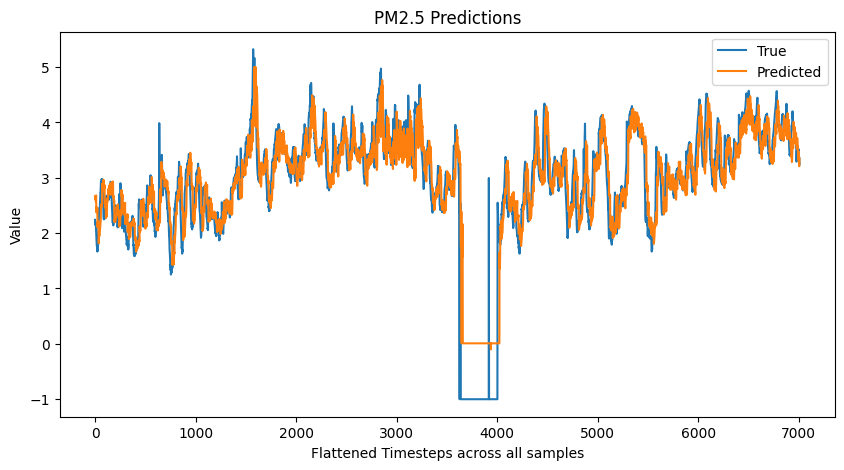

In [61]:
plot_all_predictions_flat(test_y, pred_y, feature_index=0, title="PM2.5 Predictions")

In [119]:
feature_names = ["PM2.5", "PM10", "PM1", "Temperature", "Humidity", "CO2"]

In [120]:
def plot_features_one_sample(test_y, pred_y, sample_idx=0, feature_names=None):
    # Lấy dữ liệu của sample_idx
    test_sample = test_y[sample_idx]  # shape [time_step, out]
    pred_sample = pred_y[sample_idx]  # shape [time_step, out]
    time_steps = range(test_sample.shape[0])
    
    # Nếu không truyền tên biến, tự động tạo
    if feature_names is None:
        out_dim = test_sample.shape[1]
        feature_names = [f"Feature_{i}" for i in range(out_dim)]
    
    plt.figure(figsize=(10, 5))
    # Vẽ từng feature
    for f in range(test_sample.shape[1]):
        plt.plot(time_steps, test_sample[:, f], label=f"True_{feature_names[f]}")
        plt.plot(time_steps, pred_sample[:, f], '--', label=f"Pred_{feature_names[f]}")
    
    plt.title(f"All Features")
    plt.xlabel("Time step")
    plt.ylabel("Value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [121]:
def plot_features_multiple_samples(test_y, pred_y, sample_indices=None, feature_names=None):
    if sample_indices is None:
        sample_indices = range(test_y.shape[0])
    
    for idx in sample_indices:
        plot_features_one_sample(test_y, pred_y, sample_idx=idx, feature_names=feature_names)

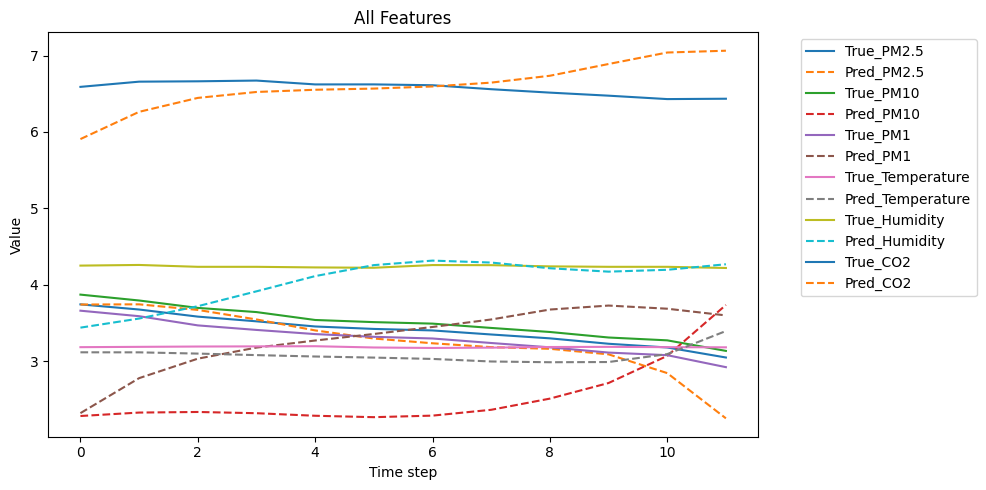

In [122]:
plot_features_multiple_samples(test_y, pred_y, sample_indices=range(1), feature_names=feature_names)